# Computer Vision

## Project: Object Search with Natural Language Description

---

The Microsoft **C**ommon **O**bjects in **CO**ntext (MS COCO) dataset is a large-scale dataset for scene understanding.  The dataset is commonly used to train and benchmark object detection, segmentation, and captioning algorithms.  

![Sample Dog Output](images/coco-examples.jpg)


This notebook is used to explore this dataset, preparing for further analysis and training of our model

## Step 1: Initialize the COCO API

We begin by initializing the [COCO API](https://github.com/cocodataset/cocoapi) used to obtain the data. We have used 2014 dataset. Download the dataset and paste it in "coco" folder.

For accessing the **C**OCO dataset,pycocotools must be installed first.For that navigate to the cocoapi-master/PythonAPI and run the following command:
"python setup.py build_ext install" for the pycocotools. 
And before running the notebook kindly activate the scripts by navigating to env/scripts/activate.

### External libraries to work with
1. data_loader. needed when loading batch of data since we are working on lots of images.

2. Model. compiled models trained and validated.

3. Vocabulary. Helper for nltk in data processing.

The functions above are accompanied with the notebook.

In [ ]:
!pip install nltk
!pip install torch===1.5.0 torchvision===0.6.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install scikit-image
!pip3 install requests
!pip install scikit-image

### A. DATABASE

In [1]:
import os
import sys
#sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO

# initialize COCO API for instance annotations
dataDir = 'coco'
dataType = 'val2014'
instances_annFile = os.path.join(dataDir, 'annotations/instances_{}.json'.format(dataType))
coco = COCO(instances_annFile)

# initialize COCO API for caption annotations
captions_annFile = os.path.join(dataDir, 'annotations/captions_{}.json'.format(dataType))
coco_caps = COCO(captions_annFile)

# get image ids 
ids = list(coco.anns.keys())

loading annotations into memory...
Done (t=4.82s)
creating index...
index created!
loading annotations into memory...
Done (t=0.27s)
creating index...
index created!


## Step 2: Plot a Sample Image

Next, we plot a random image from the dataset, along with its five corresponding captions.  
Different Images are selected everytime the cell below is run  

this dataset will be used to train  model to generate captions from images!

http://images.cocodataset.org/val2014/COCO_val2014_000000571893.jpg


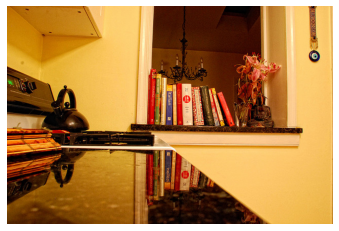

A kitchen with a teapot on the stove and books on a shelf.
A book filled windowsill in between a kitchen and dining room. 
A kitchen countertop and some books on a shelf.
A stove and some books in a kitchen.
It is all  kinds of books on the book selves. 


In [2]:
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
%matplotlib inline

# pick a random image and obtain the corresponding URL
ann_id = np.random.choice(ids)
img_id = coco.anns[ann_id]['image_id']
img = coco.loadImgs(img_id)[0]
url = img['coco_url']

# print URL and visualize corresponding image
print(url)
I = io.imread(url)
plt.axis('off')
plt.imshow(I)
plt.show()

# load and display captions
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)

## Step 3: What's to Come!

This Project is using dataset of image-caption pairs to train a CNN-RNN model to automatically generate images from captions.

![Image Captioning CNN-RNN model](images/encoder-decoder.png)

### B. PRELIMINARIES


---

In this notebook Section, we are loading and pre-processing data from the [COCO dataset](http://cocodataset.org/#home). 

We are designing a CNN-RNN model for automatically generating image captions.


The notebook is divided into below steps:
- [Step 1](#step1): Explore the Data Loader
- [Step 2](#step2): Use the Data Loader to Obtain Batches
- [Step 3](#step3): Experiment with the CNN Encoder
- [Step 4](#step4): Implement the RNN Decoder

<a id='step1'></a>
## Step 1: Explore the Data Loader

We have written [data loader](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) used load the COCO dataset in batches. 

Below we initialize the data loader by using the `get_loader` function in **data_loader.py**.  


The `get_loader` function takes as input a number of arguments that can be explored in **data_loader.py**.  

The function contains the arguments below:

1. **`transform`** - an [image transform](http://pytorch.org/docs/master/torchvision/transforms.html) specifying how to pre-process the images and convert them to PyTorch tensors before using them as input to the CNN encoder.  For now, you are encouraged to keep the transform as provided in `transform_train`.  You will have the opportunity later to choose your own image transform to pre-process the COCO images.
2. **`mode`** - one of `'train'` (loads the training data in batches) or `'test'` (for the test data). We will say that the data loader is in training or test mode, respectively.  While following the instructions in this notebook, please keep the data loader in training mode by setting `mode='train'`.
3. **`batch_size`** - determines the batch size.  When training the model, this is number of image-caption pairs used to amend the model weights in each training step.
4. **`vocab_threshold`** - the total number of times that a word must appear in the in the training captions before it is used as part of the vocabulary.  Words that have fewer than `vocab_threshold` occurrences in the training captions are considered unknown words. 
5. **`vocab_from_file`** - a Boolean that decides whether to load the vocabulary from file.  



In [3]:
## This cell is computational intensive. Might take a coupke of minutes to run
import sys
#sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
import nltk
nltk.download('punkt')
from data_loader import get_loader
from torchvision import transforms

# Define a transform to pre-process the training images.
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Set the minimum word count threshold.
vocab_threshold = 5

# Specify the batch size.
batch_size = 10

# Obtain the data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=False)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\s5229054\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


loading annotations into memory...
Done (t=0.57s)
creating index...
index created!
[0/414113] Tokenizing captions...
[100000/414113] Tokenizing captions...
[200000/414113] Tokenizing captions...
[300000/414113] Tokenizing captions...
[400000/414113] Tokenizing captions...
loading annotations into memory...


  0%|                                                                                       | 0/414113 [00:00<?, ?it/s]

Done (t=0.52s)
creating index...
index created!
Obtaining caption lengths...


100%|████████████████████████████████████████████████████████████████████████| 414113/414113 [00:50<00:00, 8178.52it/s]


From code cell above, the data loader is stored in the variable `data_loader` after run.  

You can access the corresponding dataset as `data_loader.dataset`.  This dataset is an instance of the `CoCoDataset` class in **data_loader.py**. 

### Exploring the `__getitem__` Method

The `__getitem__` method in the `CoCoDataset` class determines how an image-caption pair is pre-processed before being incorporated into a batch.  This is true for all `Dataset` classes in PyTorch; 

When the data loader is in training mode, this method begins by first obtaining the filename (`path`) of a training image and its corresponding caption (`caption`).

#### Image Pre-Processing 

Image pre-processing is relatively straightforward (from the `__getitem__` method in the `CoCoDataset` class):
```python
# Convert image to tensor and pre-process using transform
image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
image = self.transform(image)
```
After loading the image in the training folder with name `path`, the image is pre-processed using the same transform (`transform_train`) that was supplied when instantiating the data loader.  

#### Caption Pre-Processing 

The captions also need to be pre-processed and prepped for training. In this example, for generating captions, we are aiming to create a model that predicts the next token of a sentence from previous tokens, so we turn the caption associated with any image into a list of tokenized words, before casting it to a PyTorch tensor that we can use to train the network.

To understand in more detail how COCO captions are pre-processed, we'll first need to take a look at the `vocab` instance variable of the `CoCoDataset` class.  The code snippet below is pulled from the `__init__` method of the `CoCoDataset` class:
```python
def __init__(self, transform, mode, batch_size, vocab_threshold, vocab_file, start_word, 
        end_word, unk_word, annotations_file, vocab_from_file, img_folder):
        ...
        self.vocab = Vocabulary(vocab_threshold, vocab_file, start_word,
            end_word, unk_word, annotations_file, vocab_from_file)
        ...
```
From the code snippet above, you can see that `data_loader.dataset.vocab` is an instance of the `Vocabulary` class from **vocabulary.py**.  Take the time now to verify this for yourself by looking at the full code in **data_loader.py**.  

We use this instance to pre-process the COCO captions (from the `__getitem__` method in the `CoCoDataset` class):

```python
# Convert caption to tensor of word ids.
tokens = nltk.tokenize.word_tokenize(str(caption).lower())   # line 1
caption = []                                                 # line 2
caption.append(self.vocab(self.vocab.start_word))            # line 3
caption.extend([self.vocab(token) for token in tokens])      # line 4
caption.append(self.vocab(self.vocab.end_word))              # line 5
caption = torch.Tensor(caption).long()                       # line 6
```

this code converts any string-valued caption to a list of integers, before casting it to a PyTorch tensor.  To see how this code works, we'll apply it to the sample caption in the next code cell.

In [4]:
sample_caption = 'A person doing a trick on a rail while riding a skateboard.'

In **`line 1`** of the code snippet, every letter in the caption is converted to lowercase, and the [`nltk.tokenize.word_tokenize`](http://www.nltk.org/) function is used to obtain a list of string-valued tokens.  Run the next code cell to visualize the effect on `sample_caption`.

In [5]:
import nltk

sample_tokens = nltk.tokenize.word_tokenize(str(sample_caption).lower())
print(sample_tokens)

['a', 'person', 'doing', 'a', 'trick', 'on', 'a', 'rail', 'while', 'riding', 'a', 'skateboard', '.']


In **`line 2`** and **`line 3`** we initialize an empty list and append an integer to mark the start of a caption.  

This special start word (`"<start>"`) is decided when instantiating the data loader and is passed as a parameter (`start_word`).  You are **required** to keep this parameter at its default value (`start_word="<start>"`).

As you will see below, the integer `0` is always used to mark the start of a caption.

In [6]:
sample_caption = []

start_word = data_loader.dataset.vocab.start_word
print('Special start word:', start_word)
sample_caption.append(data_loader.dataset.vocab(start_word))
print(sample_caption)

Special start word: <start>
[0]


In **`line 4`**, we continue the list by adding integers that correspond to each of the tokens in the caption.

In [7]:
sample_caption.extend([data_loader.dataset.vocab(token) for token in sample_tokens])
print(sample_caption)

[0, 3, 98, 754, 3, 396, 39, 3, 1010, 207, 139, 3, 753, 18]


In **`line 5`**, we append a final integer to mark the end of the caption.  

Identical to the case of the special start word (above), the special end word (`"<end>"`) is decided when instantiating the data loader and is passed as a parameter (`end_word`).  You are **required** to keep this parameter at its default value (`end_word="<end>"`).

As you will see below, the integer `1` is always used to  mark the end of a caption.

In [8]:
end_word = data_loader.dataset.vocab.end_word
print('Special end word:', end_word)

sample_caption.append(data_loader.dataset.vocab(end_word))
print(sample_caption)

Special end word: <end>
[0, 3, 98, 754, 3, 396, 39, 3, 1010, 207, 139, 3, 753, 18, 1]


Finally, in **`line 6`**, we convert the list of integers to a PyTorch tensor and cast it to [long type]

In [9]:
import torch

sample_caption = torch.Tensor(sample_caption).long()
print(sample_caption)

tensor([   0,    3,   98,  754,    3,  396,   39,    3, 1010,  207,  139,    3,
         753,   18,    1])


And that's it!  In summary, any caption is converted to a list of tokens, with _special_ start and end tokens marking the beginning and end of the sentence:
```
[<start>, 'a', 'person', 'doing', 'a', 'trick', 'while', 'riding', 'a', 'skateboard', '.', <end>]
```
This list of tokens is then turned into a list of integers, where every distinct word in the vocabulary has an associated integer value:
```
[0, 3, 98, 754, 3, 396, 207, 139, 3, 753, 18, 1]
```
Finally, this list is converted to a PyTorch tensor.  All of the captions in the COCO dataset are pre-processed using this same procedure from **`lines 1-6`** described above.  

As you saw, in order to convert a token to its corresponding integer, we call `data_loader.dataset.vocab` as a function.  The details of how this call works can be explored in the `__call__` method in the `Vocabulary` class in **vocabulary.py**.  

```python
def __call__(self, word):
    if not word in self.word2idx:
        return self.word2idx[self.unk_word]
    return self.word2idx[word]
```

The `word2idx` instance variable is a Python dictionary that is indexed by string-valued keys (mostly tokens obtained from training captions).  For each key, the corresponding value is the integer that the token is mapped to in the pre-processing step.

Use the code cell below to view a subset of this dictionary.

In [10]:
# Preview the word2idx dictionary.
dict(list(data_loader.dataset.vocab.word2idx.items())[:10])

{'<start>': 0,
 '<end>': 1,
 '<unk>': 2,
 'a': 3,
 'very': 4,
 'clean': 5,
 'and': 6,
 'well': 7,
 'decorated': 8,
 'empty': 9}

We also print the total number of keys.

In [11]:
# Print the total number of keys in the word2idx dictionary.
print('Total number of tokens in vocabulary:', len(data_loader.dataset.vocab))

Total number of tokens in vocabulary: 8852


As you will see if you examine the code in **vocabulary.py**, the `word2idx` dictionary is created by looping over the captions in the training dataset.  If a token appears no less than `vocab_threshold` times in the training set, then it is added as a key to the dictionary and assigned a corresponding unique integer. 

In [12]:
# Modify the minimum word count threshold.
vocab_threshold = 4

# Obtain the data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=False)

loading annotations into memory...
Done (t=0.64s)
creating index...
index created!
[0/414113] Tokenizing captions...
[100000/414113] Tokenizing captions...
[200000/414113] Tokenizing captions...
[300000/414113] Tokenizing captions...
[400000/414113] Tokenizing captions...
loading annotations into memory...
Done (t=0.52s)
creating index...


  0%|▏                                                                          | 878/414113 [00:00<00:47, 8718.56it/s]

index created!
Obtaining caption lengths...


100%|████████████████████████████████████████████████████████████████████████| 414113/414113 [00:50<00:00, 8251.28it/s]


In [13]:
# Print the total number of keys in the word2idx dictionary.
print('Total number of tokens in vocabulary:', len(data_loader.dataset.vocab))

Total number of tokens in vocabulary: 9947


There are also a few special keys in the `word2idx` dictionary.  Example of the special start word (`"<start>"`) and special end word (`"<end>"`).  There is one more special token, corresponding to unknown words (`"<unk>"`).  All tokens that don't appear anywhere in the `word2idx` dictionary are considered unknown words.  In the pre-processing step, any unknown tokens are mapped to the integer `2`.

In [14]:
unk_word = data_loader.dataset.vocab.unk_word
print('Special unknown word:', unk_word)

print('All unknown words are mapped to this integer:', data_loader.dataset.vocab(unk_word))

Special unknown word: <unk>
All unknown words are mapped to this integer: 2


by pre-processing the provided nonsense words that never appear in the training captions. 

In [15]:
print(data_loader.dataset.vocab('jfkafejw'))
print(data_loader.dataset.vocab('ieowoqjf'))

2
2


when you create a new data loader, the vocabulary (`data_loader.dataset.vocab`) is saved as a pickle file in the project folder, with filename `vocab.pkl`.

Note that if `vocab_from_file=True`, then any supplied argument for `vocab_threshold` when instantiating the data loader is completely ignored.

In [16]:
# Obtain the data loader (from file). Note that it runs much faster than before!
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_from_file=True)

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.61s)
creating index...


  0%|▏                                                                        | 1076/414113 [00:00<00:38, 10681.85it/s]

index created!
Obtaining caption lengths...


100%|████████████████████████████████████████████████████████████████████████| 414113/414113 [00:52<00:00, 7919.22it/s]


In the next section, you will learn how to use the data loader to obtain batches of training data.

<a id='step2'></a>
## Step 2: Use the Data Loader to Obtain Batches

The captions in the dataset vary greatly in length.  

In the code cell below, we use this list to print the total number of captions in the training data with each length.  As you will see below, the majority of captions have length 10.  Likewise, very short and very long captions are quite rare.  

In [17]:
from collections import Counter

# Tally the total number of training captions with each length.
counter = Counter(data_loader.dataset.caption_lengths)
lengths = sorted(counter.items(), key=lambda pair: pair[1], reverse=True)
for value, count in lengths:
    print('value: %2d --- count: %5d' % (value, count))

value: 10 --- count: 86302
value: 11 --- count: 79970
value:  9 --- count: 71920
value: 12 --- count: 57652
value: 13 --- count: 37669
value: 14 --- count: 22342
value:  8 --- count: 20742
value: 15 --- count: 12840
value: 16 --- count:  7736
value: 17 --- count:  4845
value: 18 --- count:  3101
value: 19 --- count:  2017
value:  7 --- count:  1594
value: 20 --- count:  1453
value: 21 --- count:   997
value: 22 --- count:   683
value: 23 --- count:   534
value: 24 --- count:   384
value: 25 --- count:   277
value: 26 --- count:   214
value: 27 --- count:   160
value: 28 --- count:   114
value: 29 --- count:    87
value: 30 --- count:    58
value: 31 --- count:    49
value: 32 --- count:    44
value: 34 --- count:    40
value: 37 --- count:    32
value: 35 --- count:    31
value: 33 --- count:    30
value: 36 --- count:    26
value: 38 --- count:    18
value: 39 --- count:    18
value: 43 --- count:    16
value: 44 --- count:    16
value: 48 --- count:    12
value: 45 --- count:    11
v

To generate batches of training data, we begin by first sampling a caption length (where the probability that any length is drawn is proportional to the number of captions with that length in the dataset).  Then, we retrieve a batch of size `batch_size` of image-caption pairs, where all captions have the sampled length.  

the code cell below generates a batch.  The `get_train_indices` method in the `CoCoDataset` class first samples a caption length, and then samples `batch_size` indices corresponding to training data points with captions of that length.  These indices are stored below in `indices`.

These indices are supplied to the data loader, which then is used to retrieve the corresponding data points.  The pre-processed images and captions in the batch are stored in `images` and `captions`.

In [18]:
import numpy as np
import torch.utils.data as data

# Randomly sample a caption length, and sample indices with that length.
indices = data_loader.dataset.get_train_indices()
print('sampled indices:', indices)

# Create and assign a batch sampler to retrieve a batch with the sampled indices.
new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
data_loader.batch_sampler.sampler = new_sampler
    
# Obtain the batch.
images, captions = next(iter(data_loader))
    
print('images.shape:', images.shape)
print('captions.shape:', captions.shape)

# (Optional) Uncomment the lines of code below to print the pre-processed images and captions.
# print('images:', images)
# print('captions:', captions)

sampled indices: [68711, 161270, 49846, 122431, 127107, 145537, 406682, 390700, 340491, 124099]
images.shape: torch.Size([10, 3, 224, 224])
captions.shape: torch.Size([10, 15])


Each time you run the code cell above, a different caption length is sampled, and a different batch of training data is returned. 


<a id='step3'></a>
## Step 3: Experiment with the CNN Encoder

Run the code cell below to import `EncoderCNN` and `DecoderRNN` from **model.py**. 

In [21]:
# Watch for any changes in model.py, and re-load it automatically.
% load_ext autoreload
% autoreload 2

# Import EncoderCNN and DecoderRNN. 
from model import EncoderCNN, DecoderRNN

In the next code cell we define a `device` that you will use move PyTorch tensors to GPU (if CUDA is available).  Run this code cell before continuing.

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Run the code cell below to instantiate the CNN encoder in `encoder`.  

The pre-processed images from the batch in **Step 2** of this notebook are then passed through the encoder, and the output is stored in `features`.

In [23]:
# Specify the dimensionality of the image embedding.
embed_size = 256

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Initialize the encoder. (Optional: Add additional arguments if necessary.)
encoder = EncoderCNN(embed_size)

# Move the encoder to GPU if CUDA is available.
encoder.to(device)
    
# Move last batch of images (from Step 2) to GPU if CUDA is available.   
images = images.to(device)

# Pass the images through the encoder.
features = encoder(images)

print('type(features):', type(features))
print('features.shape:', features.shape)

# Check that your encoder satisfies some requirements of the project! :D
assert type(features)==torch.Tensor, "Encoder output needs to be a PyTorch Tensor." 
assert (features.shape[0]==batch_size) & (features.shape[1]==embed_size), "The shape of the encoder output is incorrect."

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 89798033.86it/s]


type(features): <class 'torch.Tensor'>
features.shape: torch.Size([10, 256])


The encoder that we provide to you uses the pre-trained ResNet-50 architecture (with the final fully-connected layer removed) to extract features from a batch of pre-processed images.  The output is then flattened to a vector, before being passed through a `Linear` layer to transform the feature vector to have the same size as the word embedding.

![Encoder](images/encoder.png)



<a id='step4'></a>
## Step 4: Implement the RNN Decoder

Before executing the next code cell, you must write `__init__` and `forward` methods in the `DecoderRNN` class in **model.py**.  (Do **not** write the `sample` method yet - you will work with this method when you reach **3_Inference.ipynb**.)

> The `__init__` and `forward` methods in the `DecoderRNN` class are the only things that you **need** to modify as part of this notebook.  You will write more implementations in the notebooks that appear later in the sequence.

decoder will be an instance of the `DecoderRNN` class and must accept as input:
- the PyTorch tensor `features` containing the embedded image features (outputted in Step 3, when the last batch of images from Step 2 was passed through `encoder`), along with
- a PyTorch tensor corresponding to the last batch of captions (`captions`) from Step 2.


![Decoder](images/decoder.png)

In the code cell below, `outputs` should be a PyTorch tensor with size `[batch_size, captions.shape[1], vocab_size]`.  Your output should be designed such that `outputs[i,j,k]` contains the model's predicted score, indicating how likely the `j`-th token in the `i`-th caption in the batch is the `k`-th token in the vocabulary.  In the next notebook of the sequence (**2_Training.ipynb**), we provide code to supply these scores to the [`torch.nn.CrossEntropyLoss`](http://pytorch.org/docs/master/nn.html#torch.nn.CrossEntropyLoss) optimizer in PyTorch.

In [24]:
# Specify the number of features in the hidden state of the RNN decoder.
hidden_size = 512

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Store the size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the decoder.
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Move the decoder to GPU if CUDA is available.
decoder.to(device)
    
# Move last batch of captions (from Step 1) to GPU if CUDA is available 
captions = captions.to(device)

# Pass the encoder output and captions through the decoder.
outputs = decoder(features, captions)

print('type(outputs):', type(outputs))
print('outputs.shape:', outputs.shape)

# Check that your decoder satisfies some requirements of the project! :D
assert type(outputs)==torch.Tensor, "Decoder output needs to be a PyTorch Tensor."
assert (outputs.shape[0]==batch_size) & (outputs.shape[1]==captions.shape[1]) & (outputs.shape[2]==vocab_size), "The shape of the decoder output is incorrect."

type(outputs): <class 'torch.Tensor'>
outputs.shape: torch.Size([10, 15, 9955])


### C. TRAINING

## Project: Object Search with Natural Language Description


---

In this notebook Section, We train our CNN-RNN model.  

Steps to navigate the notebook:
- [Step 1](#step1): Training Setup
- [Step 2](#step2): Train your Model

<a id='step1'></a>
## Step 1: Training Setup

In this step of the notebook, we customize the training of your CNN-RNN model by specifying hyperparameters and setting other options that are important to the training procedure.  The values you set now will be used when training your model in **Step 2** below.

### Task #1

Variables to be set:
- `batch_size` - the batch size of each training batch.  It is the number of image-caption pairs used to amend the model weights in each training step. 
- `vocab_threshold` - the minimum word count threshold.  Note that a larger threshold will result in a smaller vocabulary, whereas a smaller threshold will include rarer words and result in a larger vocabulary.  
- `vocab_from_file` - a Boolean that decides whether to load the vocabulary from file. 
- `embed_size` - the dimensionality of the image and word embeddings.  
- `hidden_size` - the number of features in the hidden state of the RNN decoder.  
- `num_epochs` - the number of epochs to train the model.  We recommend that you set `num_epochs=3`, but feel free to increase or decrease this number as you wish.  This paper trained a captioning model on a single state-of-the-art GPU for 3 days, but you'll soon see that you can get reasonable results in a matter of a few hours!  (_But of course, if you want your model to compete with current research, you will have to train for much longer._)
- `save_every` - determines how often to save the model weights.  We recommend that you set `save_every=1`, to save the model weights after each epoch.  This way, after the `i`th epoch, the encoder and decoder weights will be saved in the `models/` folder as `encoder-i.pkl` and `decoder-i.pkl`, respectively.
- `print_every` - determines how often to print the batch loss to the Jupyter notebook while training.  Note that you **will not** observe a monotonic decrease in the loss function while training - this is perfectly fine and completely expected!  You are encouraged to keep this at its default value of `100` to avoid clogging the notebook, but feel free to change it.
- `log_file` - the name of the text file containing - for every step - how the loss and perplexity evolved during training.


We have used Pretrained resnet50 which was provided default in the Encoder part. For Decoder part we have used simple LSTM. We tried using vocab_threshold=5, embed_size=hidden_size=512 as per suggestion in above paper and my current parameter vocab_threshold=4, embed_size=300, hidden_size=512, We was getting the same results.


Because transform_train was already provided so we used it.

```
params = list(decoder.parameters()) + list(encoder.embed.parameters()) 
```

We have tried 128 and 256 values for batch_size for 128 we was getting more stable results. using 256 batch_size we was getting more Random loss value


In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
import sys
sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from model import EncoderCNN, DecoderRNN
import math


## TODO #1: Select appropriate values for the Python variables below.
batch_size = 128          # batch size
vocab_threshold = 4        # minimum word count threshold
vocab_from_file = True    # if True, load existing vocab file
embed_size = 300           # dimensionality of image and word embeddings
hidden_size = 512          # number of features in hidden state of the RNN decoder
num_epochs = 3             # number of training epochs
save_every = 1             # determines frequency of saving model weights
print_every = 100          # determines window for printing average loss
log_file = 'training_log.txt'       # name of file with saved training loss and perplexity

# (Optional) TODO #2: Amend the image transform below.
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Build data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=vocab_from_file)

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder. 
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

# Define the loss function. 
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

# TODO #3: Specify the learnable parameters of the model.
params = list(decoder.parameters())+list(encoder.embed.parameters())

# TODO #4: Define the optimizer.
optimizer = torch.optim.Adam(params)

# Set the total number of training steps per epoch.
total_step = math.ceil(len(data_loader.dataset.caption_lengths) / data_loader.batch_sampler.batch_size)

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=1.14s)
creating index...


  0%|          | 753/414113 [00:00<01:55, 3567.63it/s]

index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [01:34<00:00, 4367.92it/s]


<a id='step2'></a>
## Step 2: Train your Model



### A Note on Tuning Hyperparameters

To figure out how well our model is doing, we looked at how the training loss and perplexity evolve during training
This will not tell you if your model is overfitting to the training data, and, unfortunately, overfitting is a problem that is commonly encountered when training image captioning models.  


In [ ]:
import torch.utils.data as data
import numpy as np
import os
import requests
import time

# Open the training log file.
f = open(log_file, 'w')

old_time = time.time()
response = requests.request("GET", 
                            "http://metadata.google.internal/computeMetadata/v1/instance/attributes/keep_alive_token", 
                            headers={"Metadata-Flavor":"Google"})

for epoch in range(1, num_epochs+1):
    
    for i_step in range(1, total_step+1):
        
        if time.time() - old_time > 60:
            old_time = time.time()
            requests.request("POST", 
                             "https://nebula.udacity.com/api/v1/remote/keep-alive", 
                             headers={'Authorization': "STAR " + response.text})
        
        # Randomly sample a caption length, and sample indices with that length.
        indices = data_loader.dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        data_loader.batch_sampler.sampler = new_sampler
        
        # Obtain the batch.
        images, captions = next(iter(data_loader))

        # Move batch of images and captions to GPU if CUDA is available.
        images = images.to(device)
        captions = captions.to(device)
        
        # Zero the gradients.
        decoder.zero_grad()
        encoder.zero_grad()
        
        # Pass the inputs through the CNN-RNN model.
        features = encoder(images)
        outputs = decoder(features, captions)
        
        # Calculate the batch loss.
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
        
        # Backward pass.
        loss.backward()
        
        # Update the parameters in the optimizer.
        optimizer.step()
            
        # Get training statistics.
        stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch, num_epochs, i_step, total_step, loss.item(), np.exp(loss.item()))
        
        # Print training statistics (on same line).
        print('\r' + stats, end="")
        sys.stdout.flush()
        
        # Print training statistics to file.
        f.write(stats + '\n')
        f.flush()
        
        # Print training statistics (on different line).
        if i_step % print_every == 0:
            print('\r' + stats)
            
    # Save the weights.
    if epoch % save_every == 0:
        torch.save(decoder.state_dict(), os.path.join('./models', 'decoder-%d.pkl' % epoch))
        torch.save(encoder.state_dict(), os.path.join('./models', 'encoder-%d.pkl' % epoch))

# Close the training log file.
f.close()

Epoch [1/3], Step [100/3236], Loss: 3.6751, Perplexity: 39.45189
Epoch [1/3], Step [200/3236], Loss: 3.3848, Perplexity: 29.5109
Epoch [1/3], Step [300/3236], Loss: 3.2617, Perplexity: 26.0942
Epoch [1/3], Step [400/3236], Loss: 3.3328, Perplexity: 28.0180
Epoch [1/3], Step [500/3236], Loss: 3.1443, Perplexity: 23.2034
Epoch [1/3], Step [600/3236], Loss: 2.8137, Perplexity: 16.6710
Epoch [1/3], Step [700/3236], Loss: 3.0678, Perplexity: 21.4936
Epoch [1/3], Step [800/3236], Loss: 3.3300, Perplexity: 27.93755
Epoch [1/3], Step [900/3236], Loss: 2.7289, Perplexity: 15.3163
Epoch [1/3], Step [1000/3236], Loss: 2.4670, Perplexity: 11.7866
Epoch [1/3], Step [1100/3236], Loss: 2.6569, Perplexity: 14.2516
Epoch [1/3], Step [1200/3236], Loss: 2.6267, Perplexity: 13.8277
Epoch [1/3], Step [1300/3236], Loss: 2.4998, Perplexity: 12.1795
Epoch [1/3], Step [1400/3236], Loss: 2.7399, Perplexity: 15.4856
Epoch [1/3], Step [1500/3236], Loss: 2.8433, Perplexity: 17.1717
Epoch [1/3], Step [1600/3236], L

# D. INFERENCE

## Project: Object Search with Natural Language Description


---

In this notebook Section, we will use our trained model to generate captions for images in the test dataset.


Links to sub-cells of the notebook:
- [Step 1](#step1): Get Data Loader for Test Dataset 
- [Step 2](#step2): Load Trained Models
- [Step 3](#step3): Finish the Sampler
- [Step 4](#step4): Clean up Captions
- [Step 5](#step5): Generate Predictions!

<a id='step1'></a>
## Step 1: Get Data Loader for Test Dataset

Before running the code cell below, we define the transform in `transform_test` that we would like to use to pre-process the test images.  

We Make sure that the transform that we define here agrees with the transform that we used to pre-process the training images (in **2_Training.ipynb**). 

In [3]:
import sys
sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from torchvision import transforms

# TODO #1: Define a transform to pre-process the testing images.
transform_test = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.RandomRotation(90),
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Create the data loader.
data_loader = get_loader(transform=transform_test,    
                         mode='test')

Vocabulary successfully loaded from vocab.pkl file!


Run the code cell below to visualize an example test image, before pre-processing is applied.

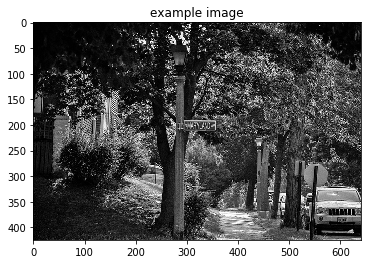

In [19]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Obtain sample image before and after pre-processing.
orig_image, image = next(iter(data_loader))

# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

<a id='step2'></a>
## Step 2: Load Trained Models

In the next code cell we define a `device` that you will use move PyTorch tensors to GPU (if CUDA is available). 

In [20]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
# Watch for any changes in model.py, and re-load it automatically.
% load_ext autoreload
% autoreload 2

import os
import torch
from model import EncoderCNN, DecoderRNN

# TODO #2: Specify the saved models to load.
encoder_file = 'encoder-2.pkl'
decoder_file = 'decoder-2.pkl'

# TODO #3: Select appropriate values for the Python variables below.
embed_size = 300
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


DecoderRNN(
  (embedd): Embedding(9955, 300)
  (lstm): LSTM(300, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=9955, bias=True)
)

<a id='step3'></a>
## Step 3: Finish the Sampler

Before executing the next code cell, we write the `sample` method in the `DecoderRNN` class in **model.py**.  This method  accepts as input a PyTorch tensor `features` containing the embedded input features corresponding to a single image.

It returns as output a Python list `output`, indicating the predicted sentence.  `output[i]` is a nonnegative integer that identifies the predicted `i`-th token in the sentence.  The correspondence between integers and tokens can be explored by examining either `data_loader.dataset.vocab.word2idx` (or `data_loader.dataset.vocab.idx2word`).


In [22]:
# Move image Pytorch Tensor to GPU if CUDA is available.
image = image.to(device)

# Obtain the embedded image features.
features = encoder(image).unsqueeze(1)

# Pass the embedded image features through the model to get a predicted caption.
output = decoder.sample(features)
print('example output:', output)

assert (type(output)==list), "Output needs to be a Python list" 
assert all([type(x)==int for x in output]), "Output should be a list of integers." 
assert all([x in data_loader.dataset.vocab.idx2word for x in output]), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

example output: [0, 3, 98, 130, 224, 39, 3, 132, 77, 32, 514, 18, 1]


<a id='step4'></a>
## Step 4: Clean up the Captions

In the code cell below, we complete the `clean_sentence` function.  It takes a list of integers (corresponding to the variable `output` in **Step 3**) as input and return the corresponding predicted sentence (as a single Python string). 

In [23]:
# TODO #4: Complete the function.
def clean_sentence(output):
    skip_indexes = [data_loader.dataset.vocab.word2idx[data_loader.dataset.vocab.start_word],
                    data_loader.dataset.vocab.word2idx[data_loader.dataset.vocab.end_word]]
    return " ".join([data_loader.dataset.vocab.idx2word[item] for item in output if not item in skip_indexes])

In [24]:
sentence = clean_sentence(output)
print('example sentence:', sentence)

assert type(sentence)==str, 'Sentence needs to be a Python string!'

example sentence: a person is sitting on a bench in the snow .


<a id='step5'></a>
## Step 5: Generate Predictions!

In the code cell below, we have written a function (`get_prediction`)  used to use to loop over images in the test dataset and print your model's predicted caption.

In [25]:
def get_prediction():
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

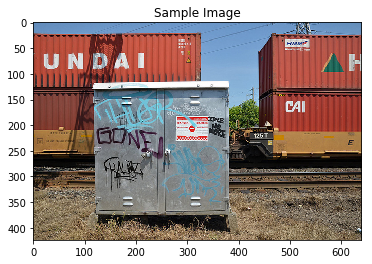

a train on a track near a platform


In [26]:
get_prediction()

### The model performed well!


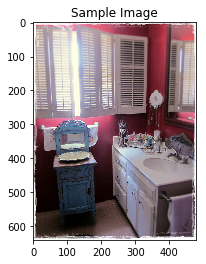

a computer desk with a keyboard and mouse .


In [27]:
get_prediction()

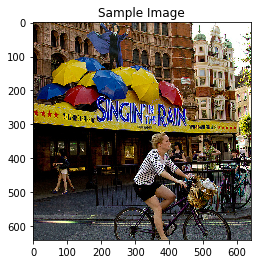

a person holding a skateboard in their hands .


In [28]:
get_prediction()

### The model could have performed better ...

We Use the next two code cells to loop over captions.  We Save the notebook when you encounter two images with relatively inaccurate captions.

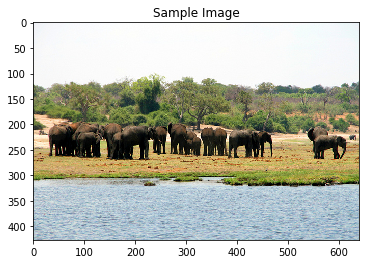

a black and white photo of a train on a train track .


In [29]:
get_prediction()

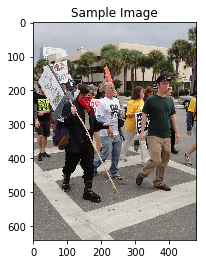

a group of people standing on a street with a kite .


In [30]:
get_prediction()

## The End